In [1]:
## Uncomment these lines if running as a google colab notebook: 
##! git clone https://github.com/kundajelab/adar_editing
##import os
##os.chdir("adar_editing/xgboost_with_shap/")
##!pip install -e https://github.com/slundberg/shap
##!pip install --upgrade xgboost
##!pip install cufflinks

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
%load_ext autoreload
%autoreload 2   

In [2]:
#helper utilities for model training and interpretation 
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap

#init_notebook_mode(connected=False)


/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d



## TTYH2 xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#1>Degenerate Dataset</a></li>
    <li><a href=#2>Degenerate Dataset: Feature Subsets</a></li>
    <li><a href=#3>Computational Dataset</a></li>
    <li><a href=#4>Computational Dataset Feature Subsets</a></li>
 </ol>


## TTYH2 Degenerate features<a name='1'>
<a href=#outline>Home</a>

In [3]:
## Read in the data 
import pandas as pd 
data=pd.read_csv("../xin_feature_matrices/ttyh2_bc_degenerate_computational.features.csv.cleaned",header=0,sep='\t',index_col=0)

In [4]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [5]:
## prepare data for training with xgboost 
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(362, 153)
{24: 32, 25: 33, 26: 41, 27: 42, 28: 31, 29: 23, 30: 24, 31: 34, 32: 25, 33: 21, 48: 56}


In [6]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [7]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [8]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

u1_length_interior_ecs
d2_exist
d1_exist
u2_3prm_cp_bulge:A:U
d1_length_hairpin
site_length_hairpin
d3_5prm_cp_hairpin
d3_exist
u2_length_bulge
d3_5prm_cp_interior
site_3prm_cp_interior:U:G
d3_length_hairpin
u3_5prm_cp_bulge:G:C
u1_5prm_cp_hairpin
d1_5prm_cp_hairpin
u1_3prm_cp_interior
d2_5prm_cp_hairpin
d3_length_interior_ecs
u2_length_interior_es
u3_length_interior_ecs
mut_prev_struct:H
u_hairpin_length
u3_struct:B
d3_3prm_cp_bulge
d2_length_hairpin
u3_length_bulge
u2_3prm_cp_interior
u3_length_interior_es
d2_5prm_cp_interior:G:C
u1_length_interior_es
u2_length_interior_ecs
mut_ref_nt:C
u1_5prm_cp_interior
mut_nt:C
d3_3prm_cp_interior
site_3prm_cp_interior:A:U
u1_length_hairpin
mut_ref_nt:G
u3_3prm_cp_bulge:G:C
mut_type:mismatch
mut_exist
d2_struct:E
d3_length_interior_es
mut_struct:B
u2_exist
d2_5prm_cp_interior:C:G
d3_length_bulge
u3_5prm_cp_interior
u3_3prm_cp_interior
u2_5prm_cp_interior
u1_exist
mut_ref_nt:U
d3_5prm_cp_bulge
u2_struct:B
u2_5prm_cp_bulge:U:G
site_5prm_cp_hairpin


In [9]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [10]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [11]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(223, 95)
(223,)
(53, 95)
(53,)
(67, 95)
(67,)


In [12]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [13]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [14]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [15]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[18:10:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-auc:0.907099	eval-mae:0.298621	eval-map:1	eval-aucpr:0.562374	eval-rmse:0.316607	train-auc:0.879349	train-mae:0.312935	train-map:1	train-aucpr:0.529177	train-rmse:0.323439
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[18:10:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[1]	eval-auc:0.907099	eval-mae:0.212941	eval-map:1	eval-aucpr:0.562374	eval-rmse:0.224948	train-auc:0.879349	train-mae:0.220825	train-map:1	train-aucpr:0.529177	train-rmse:0.228701
[18:10:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-auc:0.907099	eval-mae:0.153015	eval-map:1	eval-aucpr:0.562374	eval-rmse:0.160552	train-auc:0.879622	train-mae:0.156

[18:10:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[27]	eval-auc:0.917034	eval-mae:0.007574	eval-map:1	eval-aucpr:0.569313	eval-rmse:0.025627	train-auc:0.915181	train-mae:0.001195	train-map:1	train-aucpr:0.564817	train-rmse:0.001859
[18:10:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[28]	eval-auc:0.917043	eval-mae:0.007513	eval-map:1	eval-aucpr:0.569312	eval-rmse:0.025632	train-auc:0.915266	train-mae:0.001115	train-map:1	train-aucpr:0.564828	train-rmse:0.001684
[18:10:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[29]	eval-auc:0.917141	eval-mae:0.007463	eval-map:1	eval-aucpr:0.569354	eval-rmse:0.025613	train-auc:0.91542	train-mae:0.001055	train-map:1	train-aucpr:0.564868	train-rmse:0.001623
[18:10:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extr

In [16]:
# save to binary file for faster loading
bst.save_model('ttyh2.bc.degenerate.model')
# save model to text file 
bst.dump_model('ttyh2.bc.degenerate.raw.txt')


In [17]:
## get model predictions on the test split 
test_pred = bst.predict(dtest)

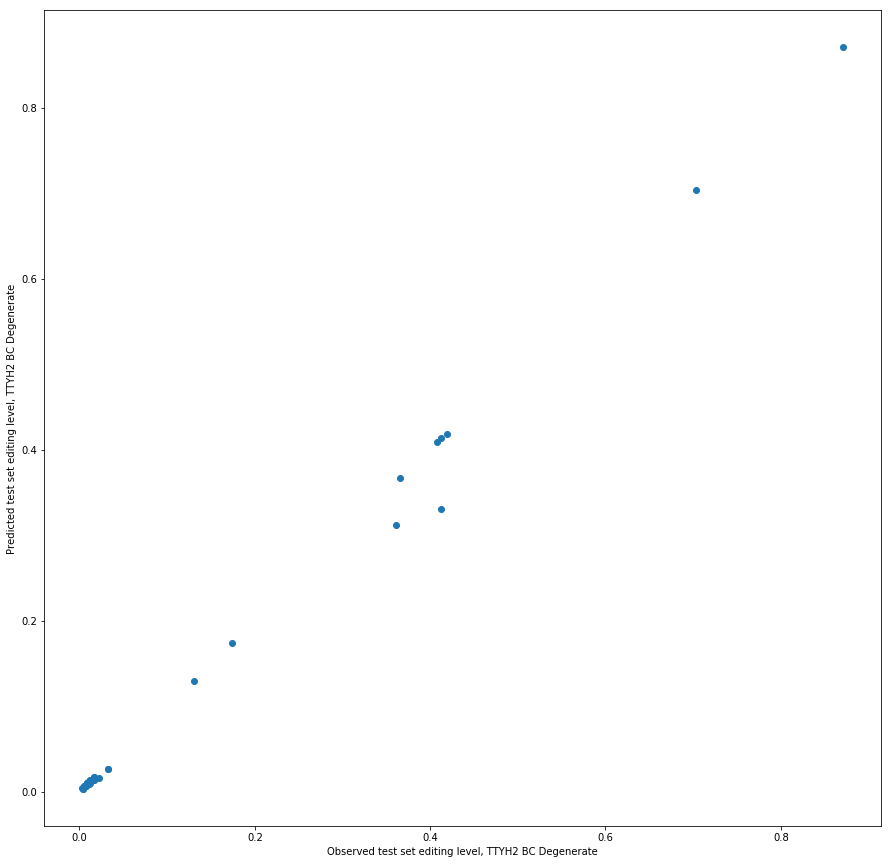

In [19]:
#plot the test set predictions 

matplotlib.rcParams['figure.figsize'] = [15, 15]
test_y=list(test_y)
test_pred=list(test_pred)
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(test_y,test_pred,'o')
plt.xlabel("Observed test set editing level, TTYH2 BC Degenerate")
plt.ylabel("Predicted test set editing level, TTYH2 BC Degenerate")
plt.show()

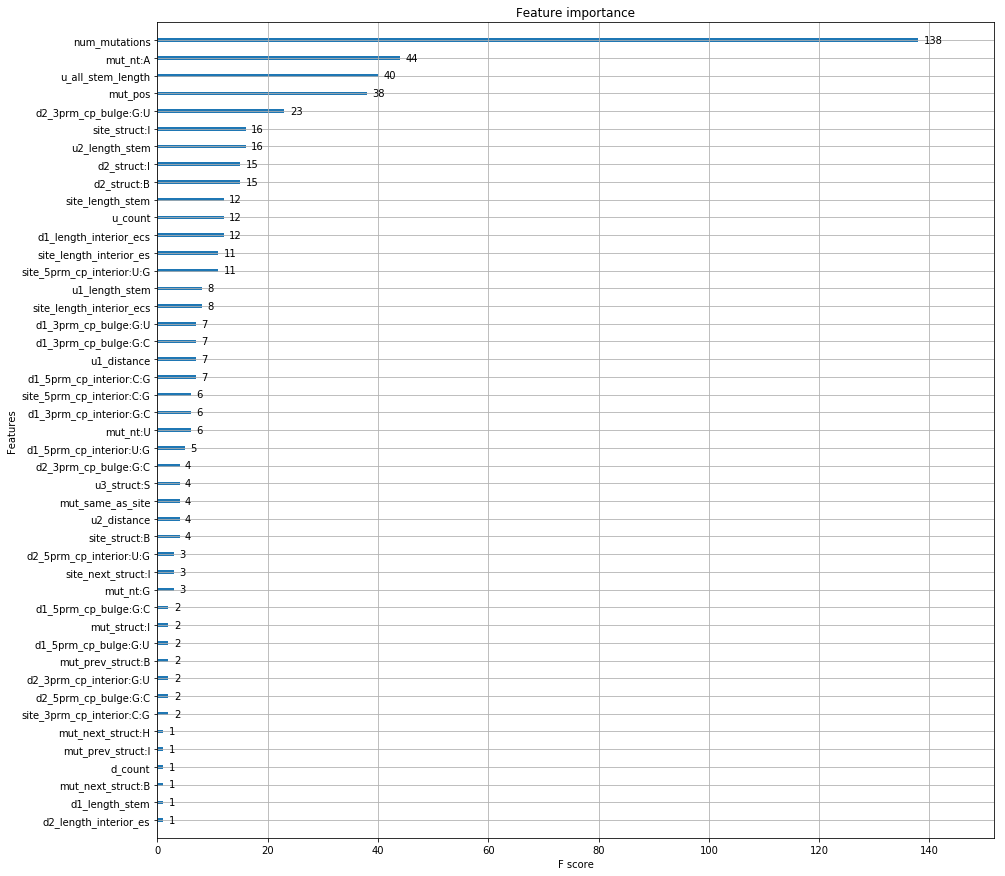

In [20]:
xgboost.plot_importance(bst)

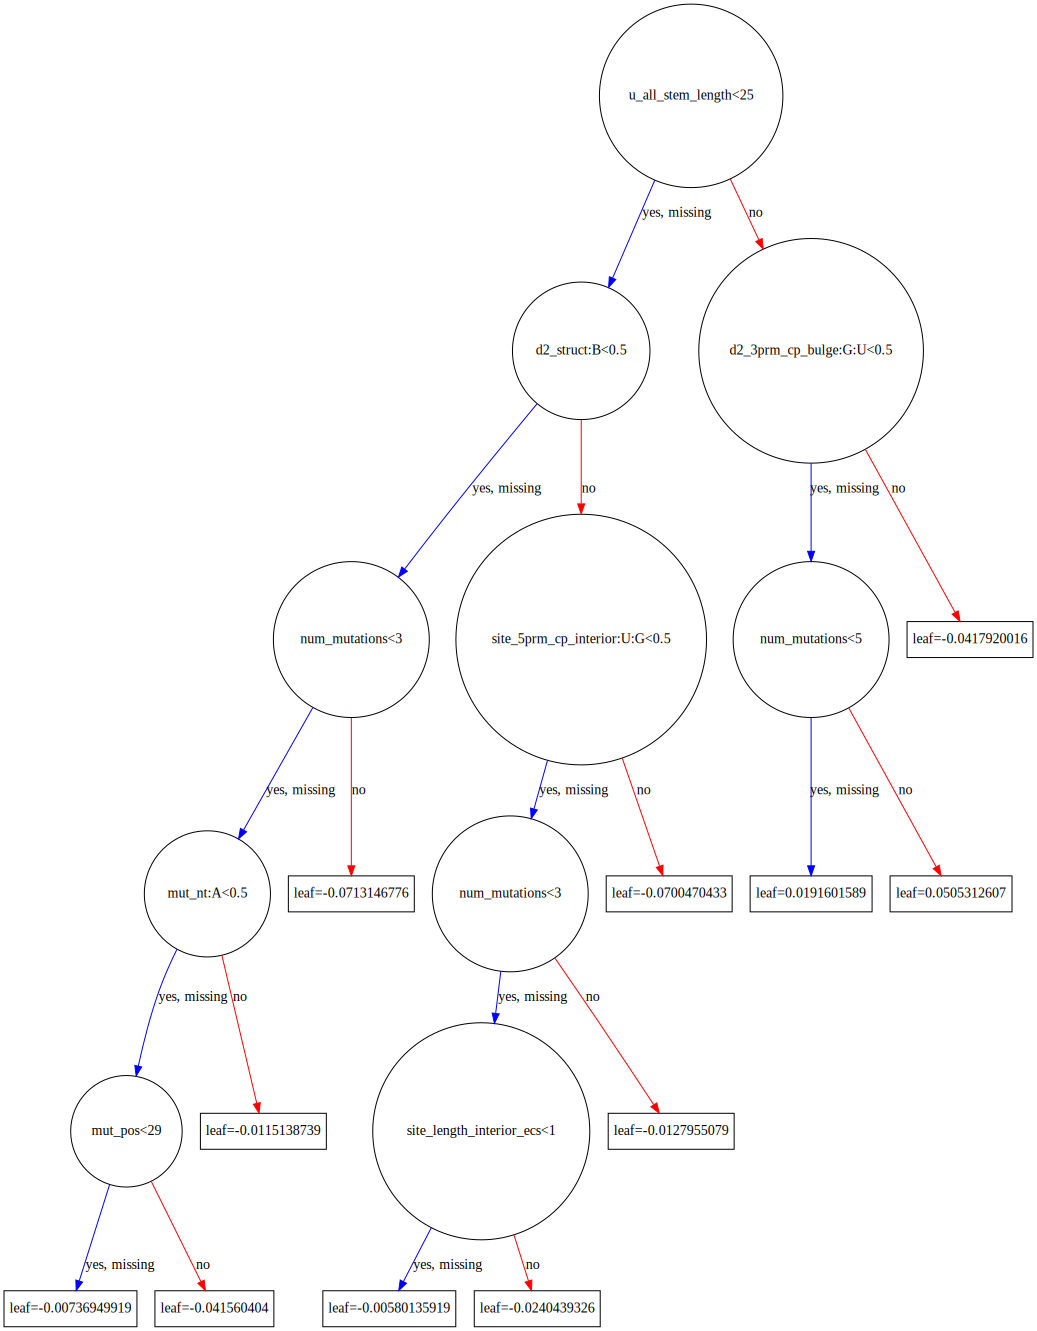

In [21]:
xgboost.to_graphviz(bst, num_trees=2)


In [22]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)


In [23]:
shap_values.shape

(67, 95)

In [24]:
# visualize prediction for isoform with the highest editing level 
max_index=test_y.index(max(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_index,:], test_X.iloc[max_index,:])

In [25]:
# visualize prediction for isoform with the lowest editing level 
min_index=test_y.index(min(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[min_index,:], test_X.iloc[min_index,:])

In [26]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

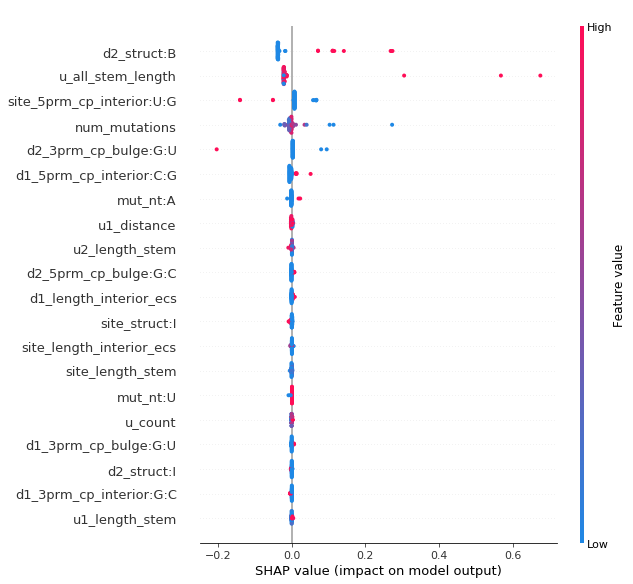

In [27]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


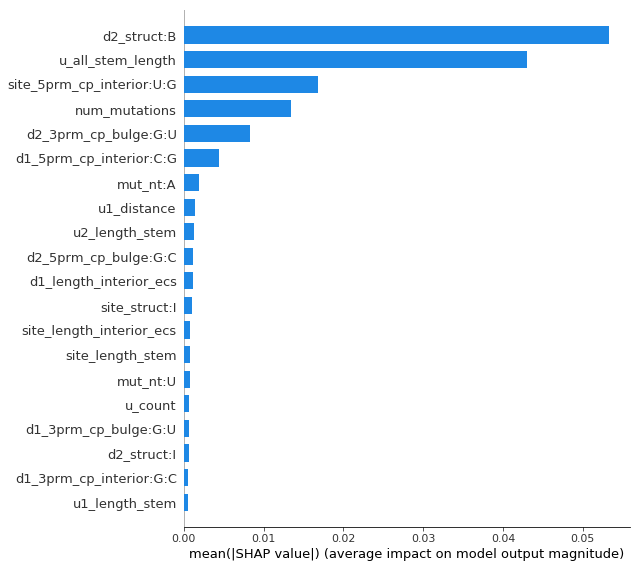

In [28]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [29]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)

In [30]:
shap_interaction_values.shape

(67, 95, 95)

In [31]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [32]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [33]:
enable_plotly_in_cell()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
tr=[trace]
iplot(tr,show_link=False)

## Degenerate Dataset: Feature Subsets<a name='2'>
<a href=#outline>Home</a>

In [34]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

In [35]:
import feature_subsets 

In [36]:
print(feature_subsets.mut)
shap_contribs_subgroup(shap_values,feature_subsets.mut)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


0.10982514

In [37]:
print(feature_subsets.site)
shap_contribs_subgroup(shap_values,feature_subsets.site)

['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.13376991

In [38]:
print(feature_subsets.u)
shap_contribs_subgroup(shap_values,feature_subsets.u)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*']


0.3029144

In [39]:
print(feature_subsets.d)
shap_contribs_subgroup(shap_values,feature_subsets.d)

['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_interior*', 'd2_3prm_cp_interior*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_interior_es*', 'd3_length_interior_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_interior*', 'd3_3prm_cp_interior*']


0.46674815

In [40]:
print(feature_subsets.u_d)
shap_contribs_subgroup(shap_values,feature_subsets.u_d)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge

0.76966256

In [41]:
print(feature_subsets.mut_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_site)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.24359506

In [42]:
print(feature_subsets.no_up)
shap_contribs_subgroup(shap_values,feature_subsets.no_up)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_

0.7103432

In [43]:
print(feature_subsets.no_down)
shap_contribs_subgroup(shap_values,feature_subsets.no_down)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_

0.54650944

In [44]:
print(feature_subsets.site_struct)
shap_contribs_subgroup(shap_values,feature_subsets.site_struct)

['site_struct', 'site_length', 'site_length_interior_es', 'site_length_interior_ecs', 'site_3prm_cp_interior']


0.024875693

In [45]:
print(feature_subsets.site_seq)
shap_contribs_subgroup(shap_values,feature_subsets.site_seq)

['site_prev_nt*', 'site_next_nt*']


0.0

In [46]:
print(feature_subsets.mut_seq)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq)

['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


0.10834736

In [47]:
print(feature_subsets.mut_seq_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq_site)

['site_prev_nt', 'site_next_nt', 'num_mutations', 'mut_pos', 'mut_site_dist', 'mut_ref_nt, mut_nt']


0.08856227

In [48]:
print(feature_subsets.no_mut)
shap_contribs_subgroup(shap_values,feature_subsets.no_mut)

['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulg

0.9034325

## TTYH2 Computational features <a name='3'>
<a href=#outline>Home</a>

In [49]:
data=pd.read_csv("../xin_feature_matrices/ttyh2_computational.features.csv.cleaned",header=0,sep='\t',index_col=0)

In [50]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [51]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(704, 188)
{1: 109, 22: 18, 23: 18, 24: 18, 25: 20, 26: 17, 27: 20, 28: 20, 29: 20, 30: 18, 31: 18, 32: 17, 33: 17, 34: 17, 35: 18, 36: 18, 37: 18, 79: 17, 80: 17, 81: 18, 82: 18, 83: 19, 84: 19, 85: 20, 86: 29, 88: 27, 89: 18, 90: 17, 91: 17, 92: 17, 93: 14, 94: 36}


In [52]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [53]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [54]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

d1_5prm_cp_interior:A:U
d1_5prm_cp_bulge:C:G
d1_3prm_cp_bulge:C:G
site_5prm_cp_bulge:U:G
d2_exist
d1_exist
d3_3prm_cp_bulge:G:C
d2_3prm_cp_interior:C:G
site_5prm_cp_bulge:G:C
mut_next_struct:E
d1_3prm_cp_interior:G:C
u2_5prm_cp_bulge:C:G
d1_length_hairpin
site_length_hairpin
d3_5prm_cp_hairpin
site_5prm_cp_interior:G:C
d1_5prm_cp_interior:G:C
u3_5prm_cp_bulge:G:C
mut_struct:E
d3_length_hairpin
u1_3prm_cp_interior
d2_5prm_cp_hairpin
u2_length_interior_es
u3_length_interior_ecs
d1_5prm_cp_bulge:G:U
mut_prev_struct:H
u_hairpin_length
d2_5prm_cp_interior:U:G
u2_3prm_cp_bulge:G:C
d1_5prm_cp_bulge:A:U
u1_3prm_cp_bulge:A:U
u3_3prm_cp_bulge:C:G
site_5prm_cp_interior:U:G
d3_3prm_cp_interior:C:G
d3_5prm_cp_interior:A:U
d2_length_hairpin
site_3prm_cp_bulge:C:G
u2_3prm_cp_interior
d1_3prm_cp_interior:A:U
u3_length_interior_es
u1_length_interior_es
u2_length_interior_ecs
d3_struct:B
u1_5prm_cp_interior
d3_5prm_cp_bulge:G:C
u3_5prm_cp_bulge:A:U
site_3prm_cp_bulge:G:U
site_3prm_cp_interior:A:U
u3_5pr

In [55]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [56]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [57]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(460, 121)
(460,)
(116, 121)
(116,)
(110, 121)
(110,)


In [58]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [59]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [60]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [61]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-auc:0.697017	eval-mae:0.230941	eval-map:1	eval-aucpr:0.278034	eval-rmse:0.251501	train-auc:0.713351	train-mae:0.244702	train-map:1	train-aucpr:0.302435	train-rmse:0.263469
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-auc:0.694148	eval-mae:0.164799	eval-map:1	eval-aucpr:0.276536	eval-rmse:0.18422	train-auc:0.723585	train-mae:0.174183	train-map:1	train-aucpr:0.310015	train-rmse:0.191736
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-auc:0.699864	eval-mae:0.125975	eval-map:1	eval-aucpr:0.275876	eval-rmse:0.143829	train-auc:0.741042	train-mae:0.1253

[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[27]	eval-auc:0.714105	eval-mae:0.040806	eval-map:1	eval-aucpr:0.284799	eval-rmse:0.065419	train-auc:0.764555	train-mae:0.014009	train-map:1	train-aucpr:0.337795	train-rmse:0.022432
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[28]	eval-auc:0.714104	eval-mae:0.040784	eval-map:1	eval-aucpr:0.284786	eval-rmse:0.06534	train-auc:0.764593	train-mae:0.013906	train-map:1	train-aucpr:0.337807	train-rmse:0.022355
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[29]	eval-auc:0.714875	eval-mae:0.040188	eval-map:1	eval-aucpr:0.286237	eval-rmse:0.064963	train-auc:0.764886	train-mae:0.013291	train-map:1	train-aucpr:0.338176	train-rmse:0.021574
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extr

[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-auc:0.715041	eval-mae:0.039486	eval-map:1	eval-aucpr:0.286251	eval-rmse:0.06507	train-auc:0.76639	train-mae:0.008103	train-map:1	train-aucpr:0.34114	train-rmse:0.015439
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-auc:0.715106	eval-mae:0.03946	eval-map:1	eval-aucpr:0.286293	eval-rmse:0.065055	train-auc:0.766401	train-mae:0.008044	train-map:1	train-aucpr:0.341144	train-rmse:0.015407
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-auc:0.715287	eval-mae:0.039449	eval-map:1	eval-aucpr:0.286671	eval-rmse:0.064785	train-auc:0.76651	train-mae:0.007846	train-map:1	train-aucpr:0.341285	train-rmse:0.015089
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra no

[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[81]	eval-auc:0.715434	eval-mae:0.038821	eval-map:1	eval-aucpr:0.286754	eval-rmse:0.064619	train-auc:0.766879	train-mae:0.005308	train-map:1	train-aucpr:0.341721	train-rmse:0.013161
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[82]	eval-auc:0.715325	eval-mae:0.038927	eval-map:1	eval-aucpr:0.286688	eval-rmse:0.064791	train-auc:0.766887	train-mae:0.00519	train-map:1	train-aucpr:0.34173	train-rmse:0.013069
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[83]	eval-auc:0.71536	eval-mae:0.038907	eval-map:1	eval-aucpr:0.286813	eval-rmse:0.064813	train-auc:0.766894	train-mae:0.005129	train-map:1	train-aucpr:0.341737	train-rmse:0.013032
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra 

[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[108]	eval-auc:0.715679	eval-mae:0.03847	eval-map:1	eval-aucpr:0.287642	eval-rmse:0.064973	train-auc:0.767044	train-mae:0.004033	train-map:1	train-aucpr:0.341875	train-rmse:0.012416
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[109]	eval-auc:0.715738	eval-mae:0.038474	eval-map:1	eval-aucpr:0.28766	eval-rmse:0.065009	train-auc:0.767043	train-mae:0.004015	train-map:1	train-aucpr:0.341874	train-rmse:0.01241
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[110]	eval-auc:0.715768	eval-mae:0.038422	eval-map:1	eval-aucpr:0.287682	eval-rmse:0.064995	train-auc:0.767054	train-mae:0.003937	train-map:1	train-aucpr:0.341879	train-rmse:0.012383
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 ext

[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[135]	eval-auc:0.714928	eval-mae:0.038633	eval-map:1	eval-aucpr:0.286946	eval-rmse:0.065239	train-auc:0.767106	train-mae:0.003426	train-map:1	train-aucpr:0.342047	train-rmse:0.012082
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[136]	eval-auc:0.714928	eval-mae:0.038633	eval-map:1	eval-aucpr:0.286946	eval-rmse:0.065239	train-auc:0.767106	train-mae:0.003426	train-map:1	train-aucpr:0.342047	train-rmse:0.012082
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[137]	eval-auc:0.714928	eval-mae:0.038633	eval-map:1	eval-aucpr:0.286946	eval-rmse:0.065239	train-auc:0.767106	train-mae:0.003426	train-map:1	train-aucpr:0.342047	train-rmse:0.012082
[18:12:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extr

In [63]:
# save to binary file for faster loading
bst.save_model('ttyh2.combined.computational.model')
# save model to text file 
bst.dump_model('ttyh2.combined.computational.raw.txt')


In [64]:
## get model predictions on the test split 
test_pred = bst.predict(dtest)

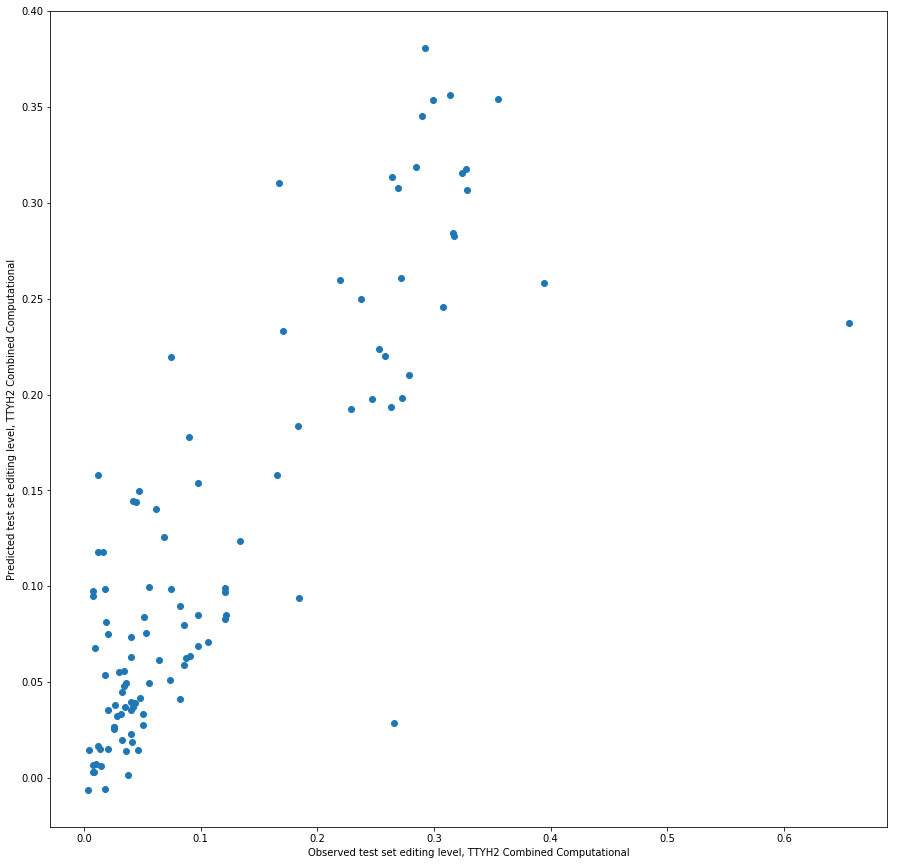

In [65]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
test_y=list(test_y)
test_pred=list(test_pred)
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(test_y,test_pred,'o')
plt.xlabel("Observed test set editing level, TTYH2 Combined Computational")
plt.ylabel("Predicted test set editing level, TTYH2 Combined Computational")
plt.show()

In [66]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)


In [67]:
shap_values.shape

(110, 121)

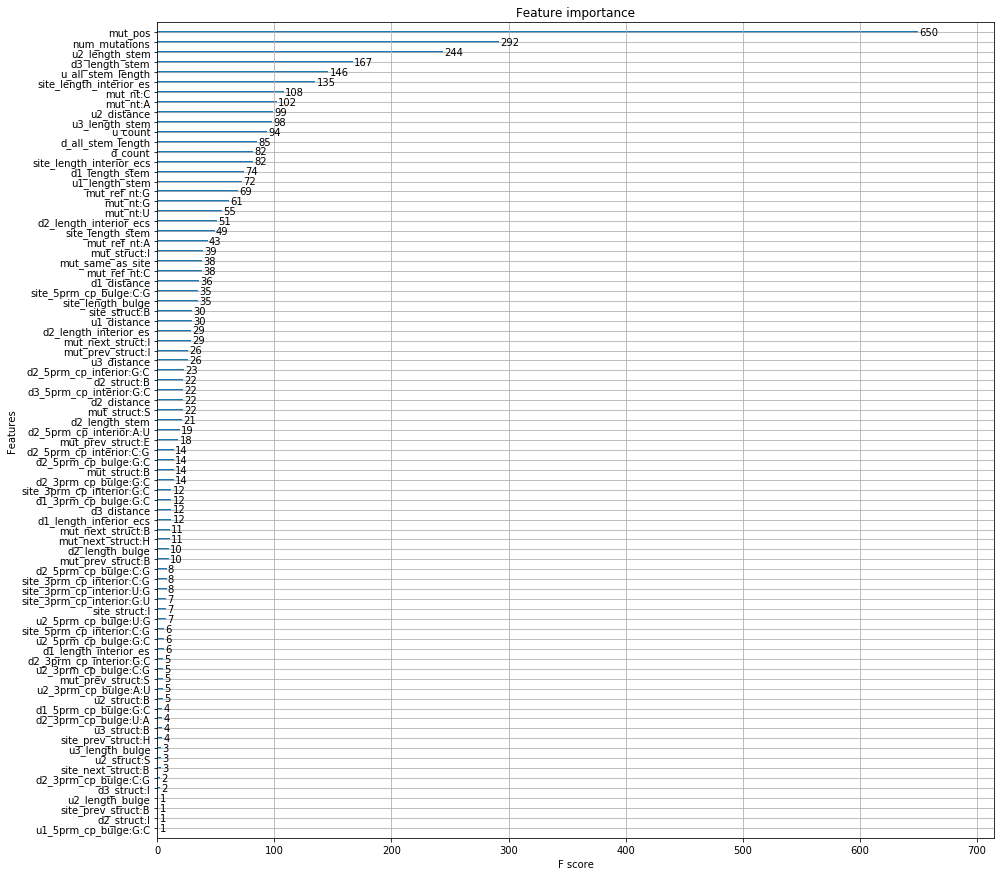

In [68]:
xgboost.plot_importance(bst)

In [69]:
# visualize prediction for isoform with highest editing level 
max_index=test_y.index(max(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_index,:], test_X.iloc[max_index,:])

In [70]:
# visualize prediction for the isoform with the lowest editing level 
min_index=test_y.index(min(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[min_index,:], test_X.iloc[min_index,:])

In [71]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

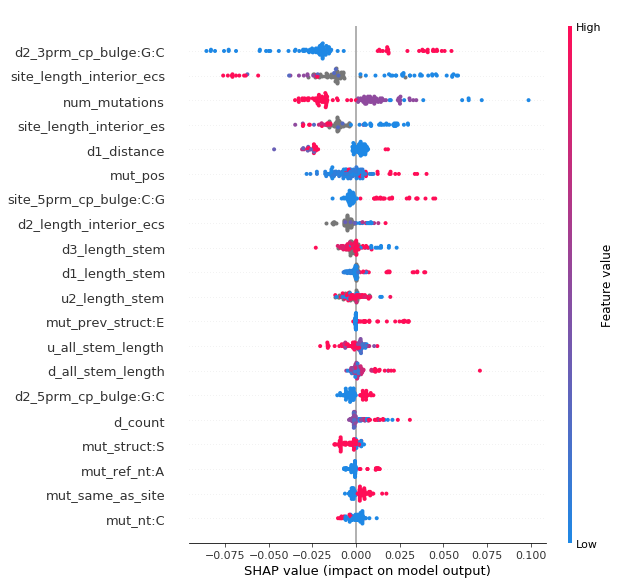

In [72]:
# summarize the effect of all the features 
shap.initjs()
shap.summary_plot(shap_values, test_X)


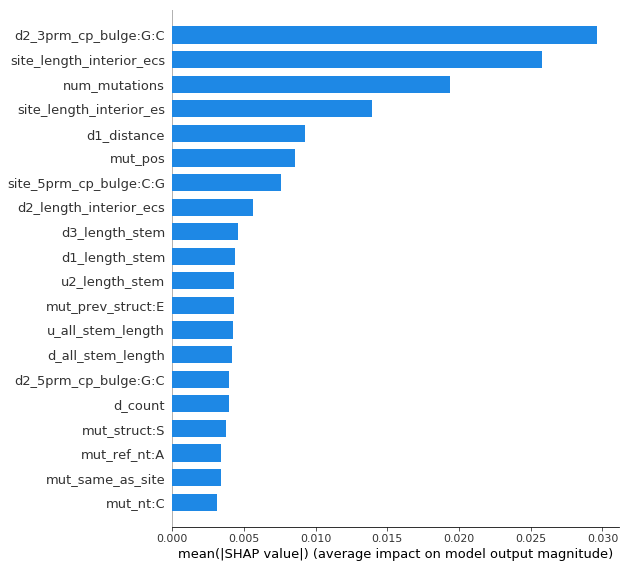

In [73]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [74]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)

In [75]:
shap_interaction_values.shape

(110, 121, 121)

In [76]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [77]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [78]:
enable_plotly_in_cell()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
tr=[trace]
iplot(tr,show_link=False)

## Computational Dataset: Feature Subsets<a name='4'>
<a href=#outline>Home</a>

In [79]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

In [80]:
import feature_subsets 

In [81]:
print(feature_subsets.mut)
shap_contribs_subgroup(shap_values,feature_subsets.mut)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


0.280783

In [82]:
print(feature_subsets.site)
shap_contribs_subgroup(shap_values,feature_subsets.site)

['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.38985264

In [83]:
print(feature_subsets.u)
shap_contribs_subgroup(shap_values,feature_subsets.u)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*']


0.09857683

In [84]:
print(feature_subsets.d)
shap_contribs_subgroup(shap_values,feature_subsets.d)

['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_interior*', 'd2_3prm_cp_interior*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_interior_es*', 'd3_length_interior_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_interior*', 'd3_3prm_cp_interior*']


0.37691537

In [85]:
print(feature_subsets.u_d)
shap_contribs_subgroup(shap_values,feature_subsets.u_d)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge

0.4754922

In [86]:
print(feature_subsets.mut_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_site)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.6706356

In [87]:
print(feature_subsets.no_up)
shap_contribs_subgroup(shap_values,feature_subsets.no_up)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_

1.047551

In [88]:
print(feature_subsets.no_down)
shap_contribs_subgroup(shap_values,feature_subsets.no_down)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_

0.7692124

In [89]:
print(feature_subsets.site_struct)
shap_contribs_subgroup(shap_values,feature_subsets.site_struct)

['site_struct', 'site_length', 'site_length_interior_es', 'site_length_interior_ecs', 'site_3prm_cp_interior']


0.40474868

In [90]:
print(feature_subsets.site_seq)
shap_contribs_subgroup(shap_values,feature_subsets.site_seq)

['site_prev_nt*', 'site_next_nt*']


0.0

In [91]:
print(feature_subsets.mut_seq)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq)

['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


0.19592826

In [92]:
print(feature_subsets.mut_seq_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq_site)

['site_prev_nt', 'site_next_nt', 'num_mutations', 'mut_pos', 'mut_site_dist', 'mut_ref_nt, mut_nt']


0.12413119

In [93]:
print(feature_subsets.no_mut)
shap_contribs_subgroup(shap_values,feature_subsets.no_mut)

['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulg

0.8653448